# Imports

In [1]:
%load_ext autoreload
%autoreload 2


import logging
from datetime import timedelta

import pandas as pd
import seaborn as sns

import core.plotting.normality as cplonorm
import helpers.hdbg as hdbg
import helpers.hprint as hprint
import research_amp.transform as ramptran

/app/core/explore.py:39: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tauton


In [2]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-da61723e-0535-4cbe-b8f4-486822540eb3.json'


# Load the data

## OHLCV

In [3]:
# Read saved 1 month of data.
ohlcv_cc = pd.read_csv("/shared_data/cc_ohlcv.csv", index_col="timestamp")
btc_ohlcv = ohlcv_cc[ohlcv_cc["full_symbol"] == "binance::BTC_USDT"]
btc_ohlcv.index = pd.to_datetime(btc_ohlcv.index)
ohlcv_cols = [
    "open",
    "high",
    "low",
    "close",
    "volume",
]
btc_ohlcv = btc_ohlcv[ohlcv_cols]
btc_ohlcv.head(3)

,open,high,low,close,volume
timestamp,,,,,
2022-01-01 00:00:00+00:00,46216.93,46271.08,46208.37,46250.00,40.57574
2022-01-01 00:01:00+00:00,46250.00,46344.23,46234.39,46312.76,42.38106
2022-01-01 00:02:00+00:00,46312.76,46381.69,46292.75,46368.73,51.29955


## Bid-ask data

Specs for the current data snapshot:
- Originally, bid-ask data from crypto-chassis appears in `seconds` frequency
- In order to be consistent with the OHLCV data one needs to resample it to `1-minute` frequency
- While resampling the `last` parameter was set for both price and sizes
- Data range: January 2022

In [4]:
# Read saved 1 month of data.
bid_ask_btc = pd.read_csv(
    "/shared_data/bid_ask_btc_jan22_1min_last.csv", index_col="timestamp"
)
bid_ask_btc.index = pd.to_datetime(bid_ask_btc.index)

# Read from crypto_chassis directly.
# Specify the params.
# full_symbols = ["binance::BTC_USDT"]
# start_date = pd.Timestamp("2022-01-01", tz="UTC")
# end_date = pd.Timestamp("2022-02-01", tz="UTC")
# Get the data.
# bid_ask_df = raccchap.read_and_resample_bid_ask_data(
#   full_symbols, start_date, end_date, "1T"
# )
bid_ask_btc.head(3)

,bid_price,bid_size,ask_price,ask_size,full_symbol
timestamp,,,,,
2022-01-01 00:00:00+00:00,46214.01,1.08286,46214.02,0.24793,binance::BTC_USDT
2022-01-01 00:01:00+00:00,46250.00,0.31064,46250.01,0.47658,binance::BTC_USDT
2022-01-01 00:02:00+00:00,46310.01,0.99036,46318.11,0.03050,binance::BTC_USDT


In [5]:
# Transform the data.
bid_ask_btc.index = pd.to_datetime(bid_ask_btc.index)
# Compute bid ask stats.
bid_ask_btc = ramptran.calculate_bid_ask_statistics(bid_ask_btc)
# Choose only necessary values.
bid_ask_btc = bid_ask_btc.swaplevel(axis=1)["binance::BTC_USDT"][
    ["bid_size", "ask_size", "bid_price", "ask_price", "mid", "quoted_spread"]
]
bid_ask_btc.index = bid_ask_btc.index.shift(-1, freq="T")
bid_ask_btc

,bid_price,bid_size,ask_price,ask_size,full_symbol
timestamp,,,,,
2022-01-01 00:00:00+00:00,46214.01,1.08286,46214.02,0.24793,binance::BTC_USDT
2022-01-01 00:01:00+00:00,46250.00,0.31064,46250.01,0.47658,binance::BTC_USDT
2022-01-01 00:02:00+00:00,46310.01,0.99036,46318.11,0.03050,binance::BTC_USDT
2022-01-01 00:03:00+00:00,46368.72,0.42379,46368.73,1.16237,binance::BTC_USDT
2022-01-01 00:04:00+00:00,46331.07,1.44732,46331.08,1.09106,binance::BTC_USDT


,ask_price,ask_size,bid_price,bid_size
,binance::BTC_USDT,binance::BTC_USDT,binance::BTC_USDT,binance::BTC_USDT
timestamp,,,,
2022-01-01 00:00:00+00:00,46214.02,0.24793,46214.01,1.08286
2022-01-01 00:01:00+00:00,46250.01,0.47658,46250.00,0.31064
2022-01-01 00:02:00+00:00,46318.11,0.03050,46310.01,0.99036
2022-01-01 00:03:00+00:00,46368.73,1.16237,46368.72,0.42379
2022-01-01 00:04:00+00:00,46331.08,1.09106,46331.07,1.44732


,bid_size,ask_size,bid_price,ask_price,mid,quoted_spread
timestamp,,,,,,
2021-12-31 23:59:00+00:00,1.08286,0.24793,46214.01,46214.02,46214.015,0.01
2022-01-01 00:00:00+00:00,0.31064,0.47658,46250.00,46250.01,46250.005,0.01
2022-01-01 00:01:00+00:00,0.99036,0.03050,46310.01,46318.11,46314.060,8.10
2022-01-01 00:02:00+00:00,0.42379,1.16237,46368.72,46368.73,46368.725,0.01
2022-01-01 00:03:00+00:00,1.44732,1.09106,46331.07,46331.08,46331.075,0.01
...,...,...,...,...,...,...
2022-01-31 23:55:00+00:00,0.16829,0.36869,38486.24,38486.25,38486.245,0.01
2022-01-31 23:56:00+00:00,0.54947,1.81137,38499.99,38500.00,38499.995,0.01
2022-01-31 23:57:00+00:00,0.02032,0.95172,38495.51,38495.52,38495.515,0.01


## Combined

In [6]:
# OHLCV + bid ask
btc = pd.concat([btc_ohlcv, bid_ask_btc], axis=1)
btc.head(3)

,open,high,low,close,volume,bid_size,ask_size,bid_price,ask_price,mid,quoted_spread
timestamp,,,,,,,,,,,
2021-12-31 23:59:00+00:00,NaN,NaN,NaN,NaN,NaN,1.08286,0.24793,46214.01,46214.02,46214.015,0.01
2022-01-01 00:00:00+00:00,46216.93,46271.08,46208.37,46250.00,40.57574,0.31064,0.47658,46250.00,46250.01,46250.005,0.01
2022-01-01 00:01:00+00:00,46250.00,46344.23,46234.39,46312.76,42.38106,0.99036,0.03050,46310.01,46318.11,46314.060,8.10


Share of close prices outside bid-ask spread: 0.459


<AxesSubplot:xlabel='timestamp'>

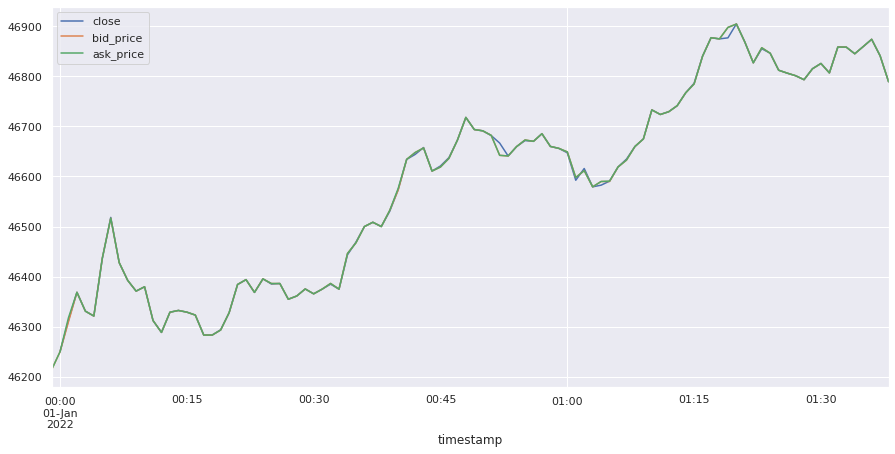

In [7]:
# Sanity check.
close_outside_ba = len(
    btc.loc[(btc["close"] > btc["ask_price"]) | (btc["close"] < btc["bid_price"])]
)
print(
    f"Share of close prices outside bid-ask spread: %.3f"
    % (close_outside_ba / len(btc))
)
btc[["close", "bid_price", "ask_price"]].head(100).plot(figsize=(15, 7))

# Analysis

## Functions

In [8]:
def compute_execution(df: pd.DataFrame, is_buy: bool = True) -> pd.DataFrame:
    """
    Compute execution statistics in the trade interval for a given limit order.
    Collected statistics for a given trading period:

    - executed_volume: the volume that was available in the bars where there was execution.
    - executed_notional: the amount of dollars we could have executed assuming to sweep
    the first level of the order book.
    - executed_bars: in how many bars there was an execution.
    - executed_avg_price: average price for which there was execution

    :param df: data of time interval for trading period
    :param is_buy: transaction side (i.e., True for `buy`, False for `sell`)
    :return: calculated stats for a given trade interval
    """
    result = {}
    # Execution is triggered if `limit_price` is inside [low,high] interval of close price.
    # It is guarantee that there was execution in [low, high] of close price, and thus our
    # order would have triggered.
    # TODO(gp): more precisely we should use [low, high] of ask / bid (depending on the direction)
    # to trigger an execution.
    df["execution_is_triggered"] = (df["high"] >= df["limit_price"]) & (
        df["low"] <= df["limit_price"]
    )
    # Set the volume that will be triggered during transaction.
    if is_buy:
        size_col = "ask_size"
    else:
        size_col = "bid_size"
    # Execution volume.
    result["executed_volume"] = (
        df[size_col] * df["execution_is_triggered"]
    ).sum()
    # The notional executed volume.
    result["executed_notional"] = (df[size_col] * df["limit_price"]).sum()
    # Executed bars.
    result["executed_bars"] = df["execution_is_triggered"].sum()
    # Executed average price.
    result["executed_avg_price"] = (
        df["limit_price"] * df["execution_is_triggered"]
    ).mean()
    # Build a DataFrame with all the results and mark it at the end of the interval.
    result = pd.DataFrame(result, index=[df.index[-1]])
    return result


def compute_transaction_cost(
    df,
    start_time,
    interval_in_mins: int = 10,
    trade_in_mins: int = 5,
    is_buy: bool = True,
) -> pd.DataFrame:
    """
    Given prices and ask / bids in the bars (a, b] marked at the end of the
    interval, compute the cost to enter a buy / sell trade in the interval
    [start_time, start_time + interval_in_mins) and the pnl from holding
    between.

    Collected statistics for a given trading period:

    - Stats from `compute_execution()`
    - close_price_holding_period: close price at the end of holding period
    - trade_pnl_per_share: difference between start and close price (holding period)
    - holding_notional: volume obtained from the trading period multiplied by close_price_holding_period
    - notional_diff: difference between notional trading values from trading and holding periods

    :param df: combined OHLCV and bid-ask data
    :param interval_in_mins: number of minutes during holding period
    :param trade_in_mins: number of minutes during trading period
    :param is_buy: transaction side (i.e., True for `buy`, False for `sell`)
    :return: transaction costs stats for the interval
    """
    hdbg.dassert_lt(trade_in_mins, interval_in_mins)
    # The position is entered in the interval:
    # [start_time, start_time + trade_in_mins)
    trade_in_mins = timedelta(minutes=trade_in_mins)
    trade_interval = df.loc[
        start_time : start_time + trade_in_mins - timedelta(minutes=1)
    ].copy()
    # Add "limit_price" to df.
    if is_buy:
        trade_interval["limit_price"] = (
            trade_interval.loc[start_time]["ask_price"] - 0.01
        )
    else:
        trade_interval["limit_price"] = (
            trade_interval.loc[start_time]["bid_price"] + 0.01
        )
    result = compute_execution(trade_interval, is_buy)
    # The position is held during the interval:
    # [start_time + trade_in_mins, start_time + interval_in_mins).
    interval_in_mins = (
        timedelta(minutes=interval_in_mins) + trade_in_mins - timedelta(minutes=1)
    )
    # Start / end prices for the holding period.
    start_price = df.loc[start_time + trade_in_mins]["close"]
    end_price = df.loc[start_time + interval_in_mins]["close"]
    # Difference between start and close price (holding period).
    if is_buy:
        trade_pnl_per_share = start_price - end_price
    else:
        trade_pnl_per_share = -(start_price - end_price)
    result["trade_pnl_per_share"] = trade_pnl_per_share
    # Close price at the end of holding period.
    result["close_price_holding_period"] = end_price
    # Notional value of holding position.
    result["holding_notional"] = (
        result["close_price_holding_period"] * result["executed_volume"]
    )
    # Difference between notional trading values from trading and holding periods.
    result["notional_diff"] = (
        result["holding_notional"] - result["executed_notional"]
    )
    return result


def calculate_number_of_total_intervals(
    df: pd.DataFrame, total_interval: int
) -> range:
    """
    Computes the number of iterations in the loop, so every interval can be
    processed.

    :param df: combined OHLCV and bid-ask data
    :param total_interval: the sum of intervals for holding and trading periods
    """
    trans_int_in_sec = total_interval * 60
    total_period = (df.index.max() - df.index.min()).total_seconds()
    num_intervals = total_period / trans_int_in_sec
    num_intervals = range(int(num_intervals))
    return num_intervals

In [9]:
# Set the params.
start_time = btc.index.min()
interval_in_mins = 10
trade_in_mins = 5
total_interval = interval_in_mins + trade_in_mins
is_buy = True
# Set the number of total intervals.
num_intervals = calculate_number_of_total_intervals(btc, total_interval)
# Calculate transaction cost stats for each period inside the sample.
final_result = []
for i in num_intervals:
    # Calculate transaction cost for each interval.
    result_tmp = compute_transaction_cost(
        btc, start_time, interval_in_mins, trade_in_mins, is_buy
    )
    final_result.append(result_tmp)
    # Define new `start_time` for the next period.
    start_time = start_time + timedelta(minutes=total_interval)
# Combine the stats from all periods.
final_result = pd.concat(final_result)
final_result.head(3)

,executed_volume,executed_notional,executed_bars,executed_avg_price,trade_pnl_per_share,close_price_holding_period,holding_notional,notional_diff
2022-01-01 00:03:00+00:00,0.47658,139032.076244,1,9242.802,-7.66,46329.00,22079.474820,-116952.601424
2022-01-01 00:18:00+00:00,0.46022,47282.326455,2,18533.004,-67.48,46361.38,21336.434304,-25945.892151
2022-01-01 00:33:00+00:00,3.18477,147695.014506,5,46375.410,-214.19,46657.84,148594.489097,899.474591


# The distribution of money made - money spent

In [10]:
post_results = final_result.copy()
post_results["notional_diff"].describe()

count    2.976000e+03
mean    -6.145572e+04
std      1.169567e+05
min     -3.821649e+06
25%     -7.873457e+04
50%     -3.459562e+04
75%     -1.114034e+04
max      2.538349e+03
Name: notional_diff, dtype: float64

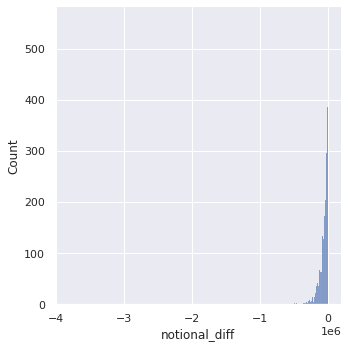

In [11]:
sns.displot(post_results, x="notional_diff")

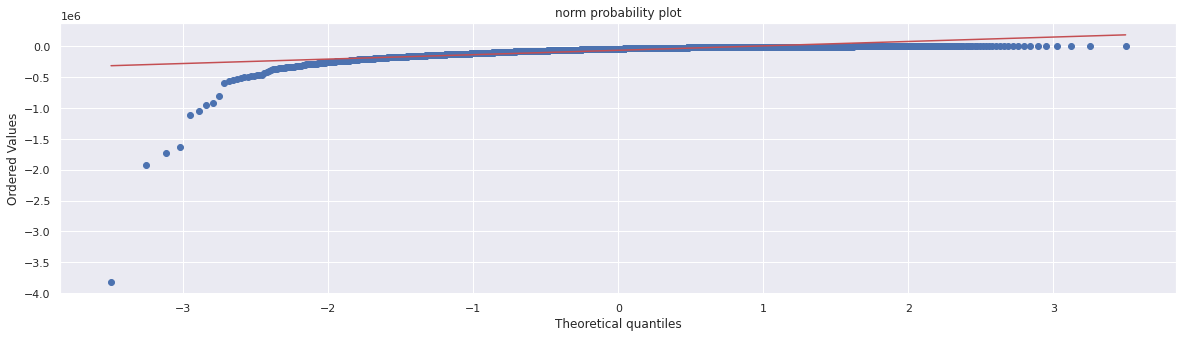

In [12]:
# Visualize the result
cplonorm.plot_qq(post_results["notional_diff"])